In [2]:
from brian2 import *
from DynapSE import DynapSE
from scipy import signal
import matplotlib.pyplot as plt
from data_loader import load_pickle
from ADM import ADM
import seaborn as sns
sns.set()

In [3]:
def ADM_spikes(signal):
    
    # generate spikes
    up_spikes, down_spikes = ADM(
        PPG_signal,
        up_threshold=10,
        down_threshold=10,
        sampling_rate=64,
        refractory_period=0
    )
    
    return SpikeGeneratorGroup(1, np.zeros(len(up_spikes)), up_spikes * second)

In [27]:
# initialize synapse parameters
RANDOM = False
n_neurons = 10

I_tau_syn_exc_mean = 10 # pA
I_tau_syn_exc_var = 10 # pA
I_tau_syn_inh_mean = 10 # pA
I_tau_syn_inh_var = 10 # pA

if RANDOM:
    I_tau_syn_exc_values = abs(np.random.normal(I_tau_syn_exc_mean, I_tau_syn_exc_var, n_neurons))
    I_tau_syn_inh_values = abs(np.random.normal(I_tau_syn_inh_mean, I_tau_syn_inh_var, n_neurons))
else:
    I_tau_syn_exc_values = np.linspace(30.5, 33, n_neurons)
    I_tau_syn_inh_values = np.ones(n_neurons) * 32
I_tau_syn_inh_values = np.linspace(1, 33, n_neurons)

In [92]:
counts = []
num_frequencies = 10
frequencies = np.linspace(0.5, 4, num_frequencies)
for signal_freq in frequencies:

    device.reinit()
    device.activate()
    defaultclock.dt = 500 * us
    duration = 5 * second

    network = Network()
    chip = DynapSE(network)

    # generate spikes
    fs = 32 # Hz
    signal = np.sin(np.arange(0, duration / second, 1 / fs) * signal_freq * 2 * np.pi)
    up_spikes, down_spikes = ADM(
        signal,
        up_threshold=0.001,
        down_threshold=0.001,
        sampling_rate=fs,
        refractory_period=0.001
    )

    spike_generator_up = SpikeGeneratorGroup(1, np.zeros(len(up_spikes)), up_spikes * second)
    spike_generator_down = SpikeGeneratorGroup(1, np.zeros(len(down_spikes)), down_spikes * second)

    # instantiate neurons, synapses
    DPI_neurons  = chip.get_neurons(n_neurons, 'Core_1')
    DPI_synapses_up = chip.add_connection(spike_generator_up, DPI_neurons, synapse_type='AMPA')
    DPI_synapses_down = chip.add_connection(spike_generator_down, DPI_neurons, synapse_type='GABA_B')
    DPI_synapses_up.connect(True)
    DPI_synapses_down.connect(True)
    DPI_synapses_up.weight = 0
    DPI_synapses_down.weight = 100

    # set parameters of neurons, synapses
    DPI_neurons.I_tau_syn_exc2 = I_tau_syn_exc_values * pA
    DPI_neurons.I_g_syn_exc2 = I_tau_syn_exc_values * pA
    DPI_neurons.I_tau_syn_inh = I_tau_syn_inh_values * pA
    DPI_neurons.I_g_syn_inh = [I_tau_syn_inh_values * pA

    # create monitors
    mon_synapse_up_state = StateMonitor(DPI_synapses_up, 'I_syn_exc2', record=True)
    mon_synapse_down_state = StateMonitor(DPI_synapses_down, 'I_syn_inh', record=True)
    mon_neuron_state  = StateMonitor(DPI_neurons,  'Imem', record=True)
    mon_neuron_ahp  = StateMonitor(DPI_neurons,  'Iahp', record=True)
    mon_neuron_input  = SpikeMonitor(spike_generator_up, name='mon_neuron_input')
    mon_neuron_output = SpikeMonitor(DPI_neurons, name='mon_neuron_output')

    # add elements to network
    network.add([spike_generator_up, spike_generator_down, DPI_neurons, DPI_synapses_up, DPI_synapses_down,
                 mon_synapse_up_state, mon_synapse_down_state, mon_neuron_state, mon_neuron_input, 
                 mon_neuron_output, mon_neuron_ahp])

    # simulation
    network.run(duration)
    
    # save spike counts
    counts.append(mon_neuron_output.count)


10 neurons are allocated from Core_1.


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_exc2_post += ((I_wo_syn_exc2_post * weight) * I_g_syn_exc2_post) / (I_tau_syn_exc2_post * (1.0 + (I_g_syn_exc2_post / I_syn_exc2_post))) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_inh_post += ((I_wo_syn_inh_post * (- weight)) * I_g_syn_inh_post) / (I_tau_syn_inh_post * (1.0 + (I_g_syn_inh_post / I_syn_inh_post))) (in-place)"
 [brian2.codegen.generators.base]


10 neurons are allocated from Core_1.


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_exc2_post += ((I_wo_syn_exc2_post * weight) * I_g_syn_exc2_post) / (I_tau_syn_exc2_post * (1.0 + (I_g_syn_exc2_post / I_syn_exc2_post))) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_inh_post += ((I_wo_syn_inh_post * (- weight)) * I_g_syn_inh_post) / (I_tau_syn_inh_post * (1.0 + (I_g_syn_inh_post / I_syn_inh_post))) (in-place)"
 [brian2.codegen.generators.base]


10 neurons are allocated from Core_1.


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_exc2_post += ((I_wo_syn_exc2_post * weight) * I_g_syn_exc2_post) / (I_tau_syn_exc2_post * (1.0 + (I_g_syn_exc2_post / I_syn_exc2_post))) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_inh_post += ((I_wo_syn_inh_post * (- weight)) * I_g_syn_inh_post) / (I_tau_syn_inh_post * (1.0 + (I_g_syn_inh_post / I_syn_inh_post))) (in-place)"
 [brian2.codegen.generators.base]


10 neurons are allocated from Core_1.


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_exc2_post += ((I_wo_syn_exc2_post * weight) * I_g_syn_exc2_post) / (I_tau_syn_exc2_post * (1.0 + (I_g_syn_exc2_post / I_syn_exc2_post))) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_inh_post += ((I_wo_syn_inh_post * (- weight)) * I_g_syn_inh_post) / (I_tau_syn_inh_post * (1.0 + (I_g_syn_inh_post / I_syn_inh_post))) (in-place)"
 [brian2.codegen.generators.base]


10 neurons are allocated from Core_1.


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_exc2_post += ((I_wo_syn_exc2_post * weight) * I_g_syn_exc2_post) / (I_tau_syn_exc2_post * (1.0 + (I_g_syn_exc2_post / I_syn_exc2_post))) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_inh_post += ((I_wo_syn_inh_post * (- weight)) * I_g_syn_inh_post) / (I_tau_syn_inh_post * (1.0 + (I_g_syn_inh_post / I_syn_inh_post))) (in-place)"
 [brian2.codegen.generators.base]


Text(0.5, 1.0, 'Firing rate of DPI neurons with different excitatory synaptic time constants')

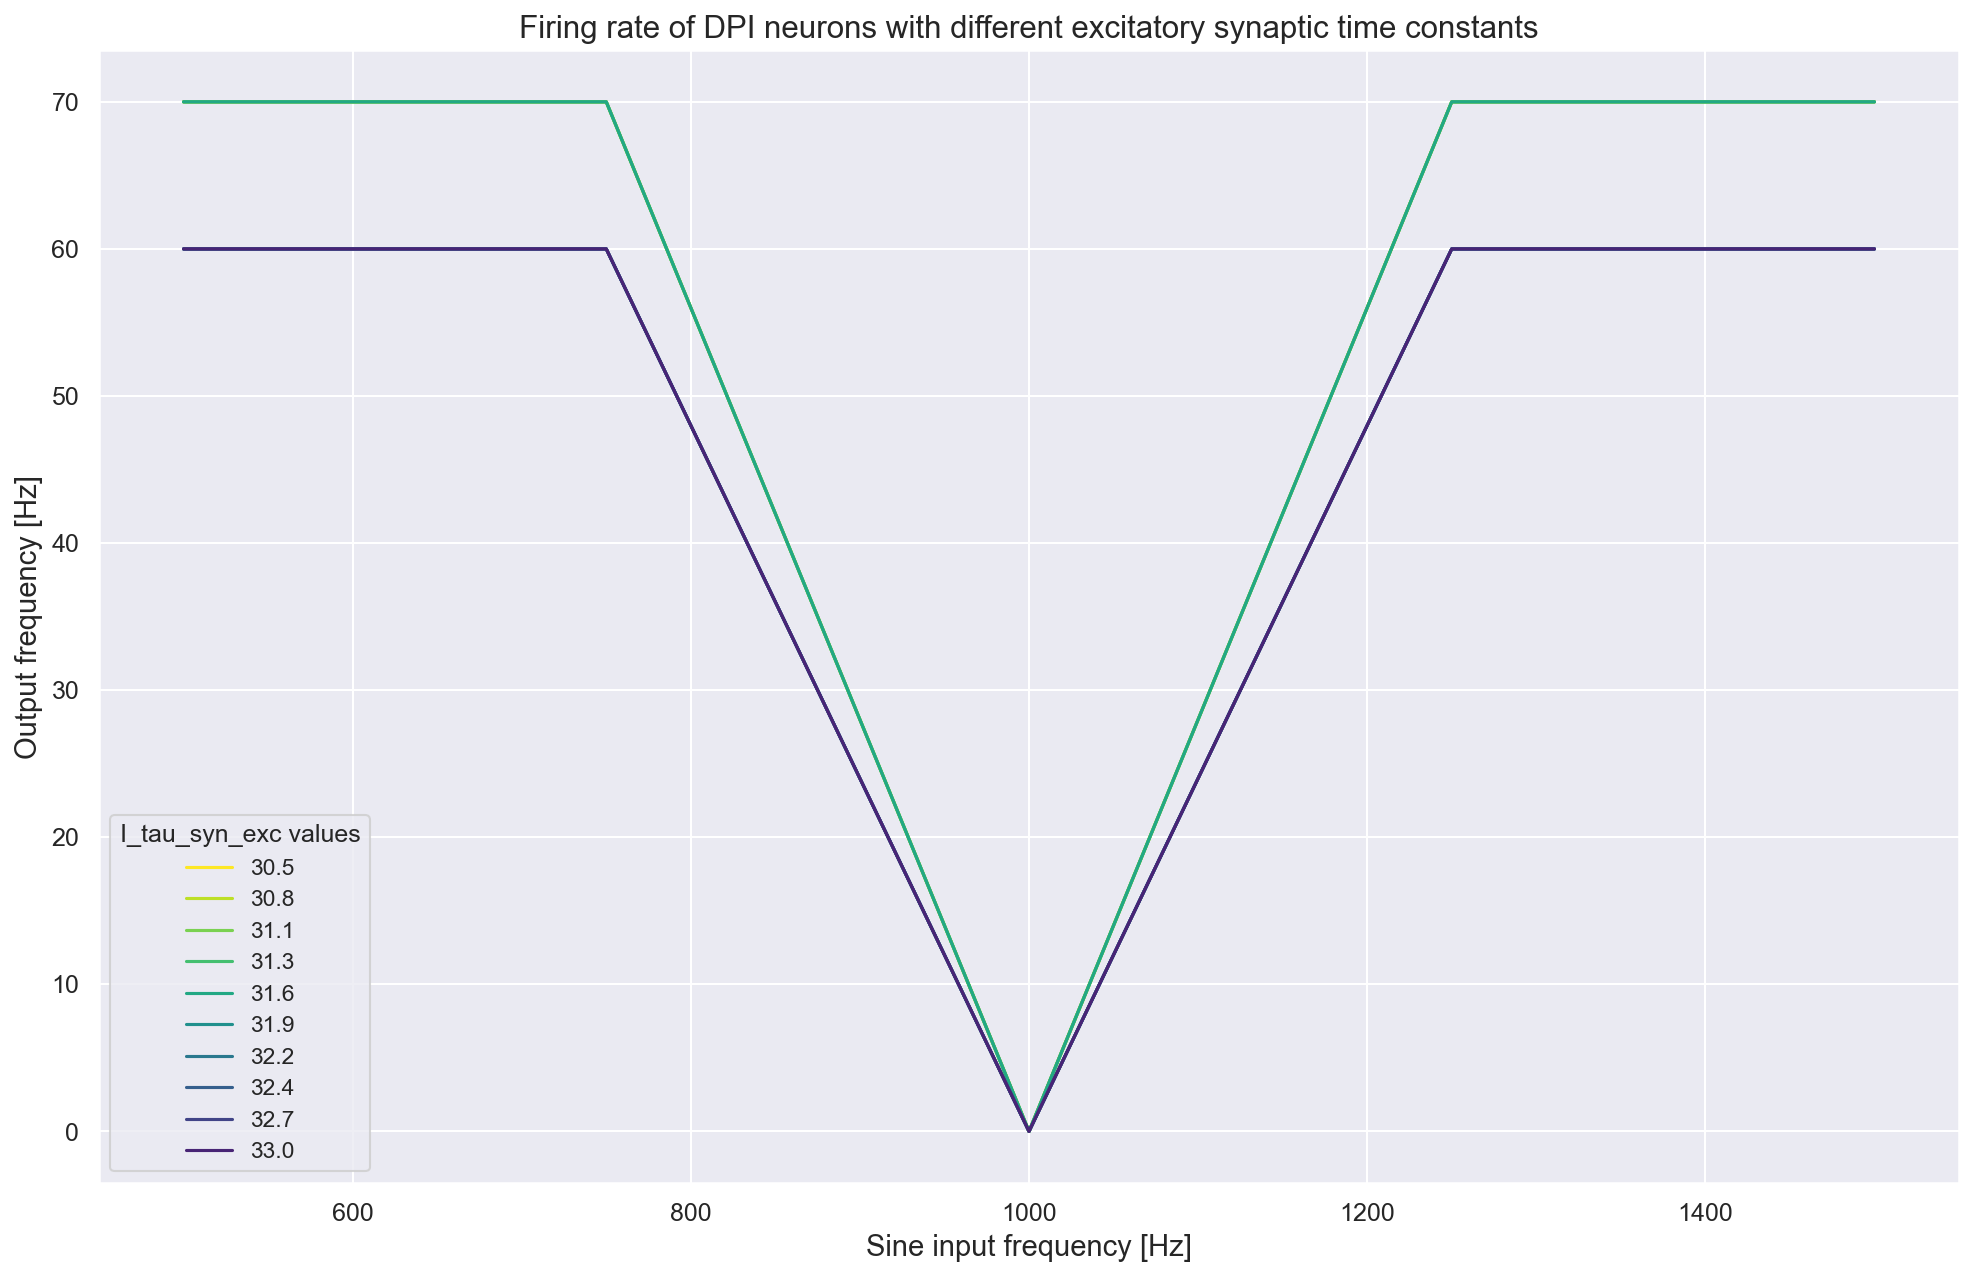

In [93]:
counts = np.array(counts)
plt.figure(figsize=(16,10),dpi=150)
norm = mpl.colors.Normalize(vmin=0, vmax=counts.shape[1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('viridis_r'))
for i in range(counts.shape[1]):
    plt.plot(frequencies, counts[:, i] / duration / second, label=round(I_tau_syn_exc_values[i], 1), color=cmap.to_rgba(i))
    #plt.fill_between(frequencies, counts[:, i] / duration / second, color=cmap.to_rgba(i), alpha=1)
plt.legend(title='I_tau_syn_exc values')
plt.xticks(fontsize=12)
plt.xlabel('Sine input frequency [Hz]', fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Output frequency [Hz]', fontsize=14)
plt.title('Firing rate of DPI neurons with different excitatory synaptic time constants', fontsize=15)


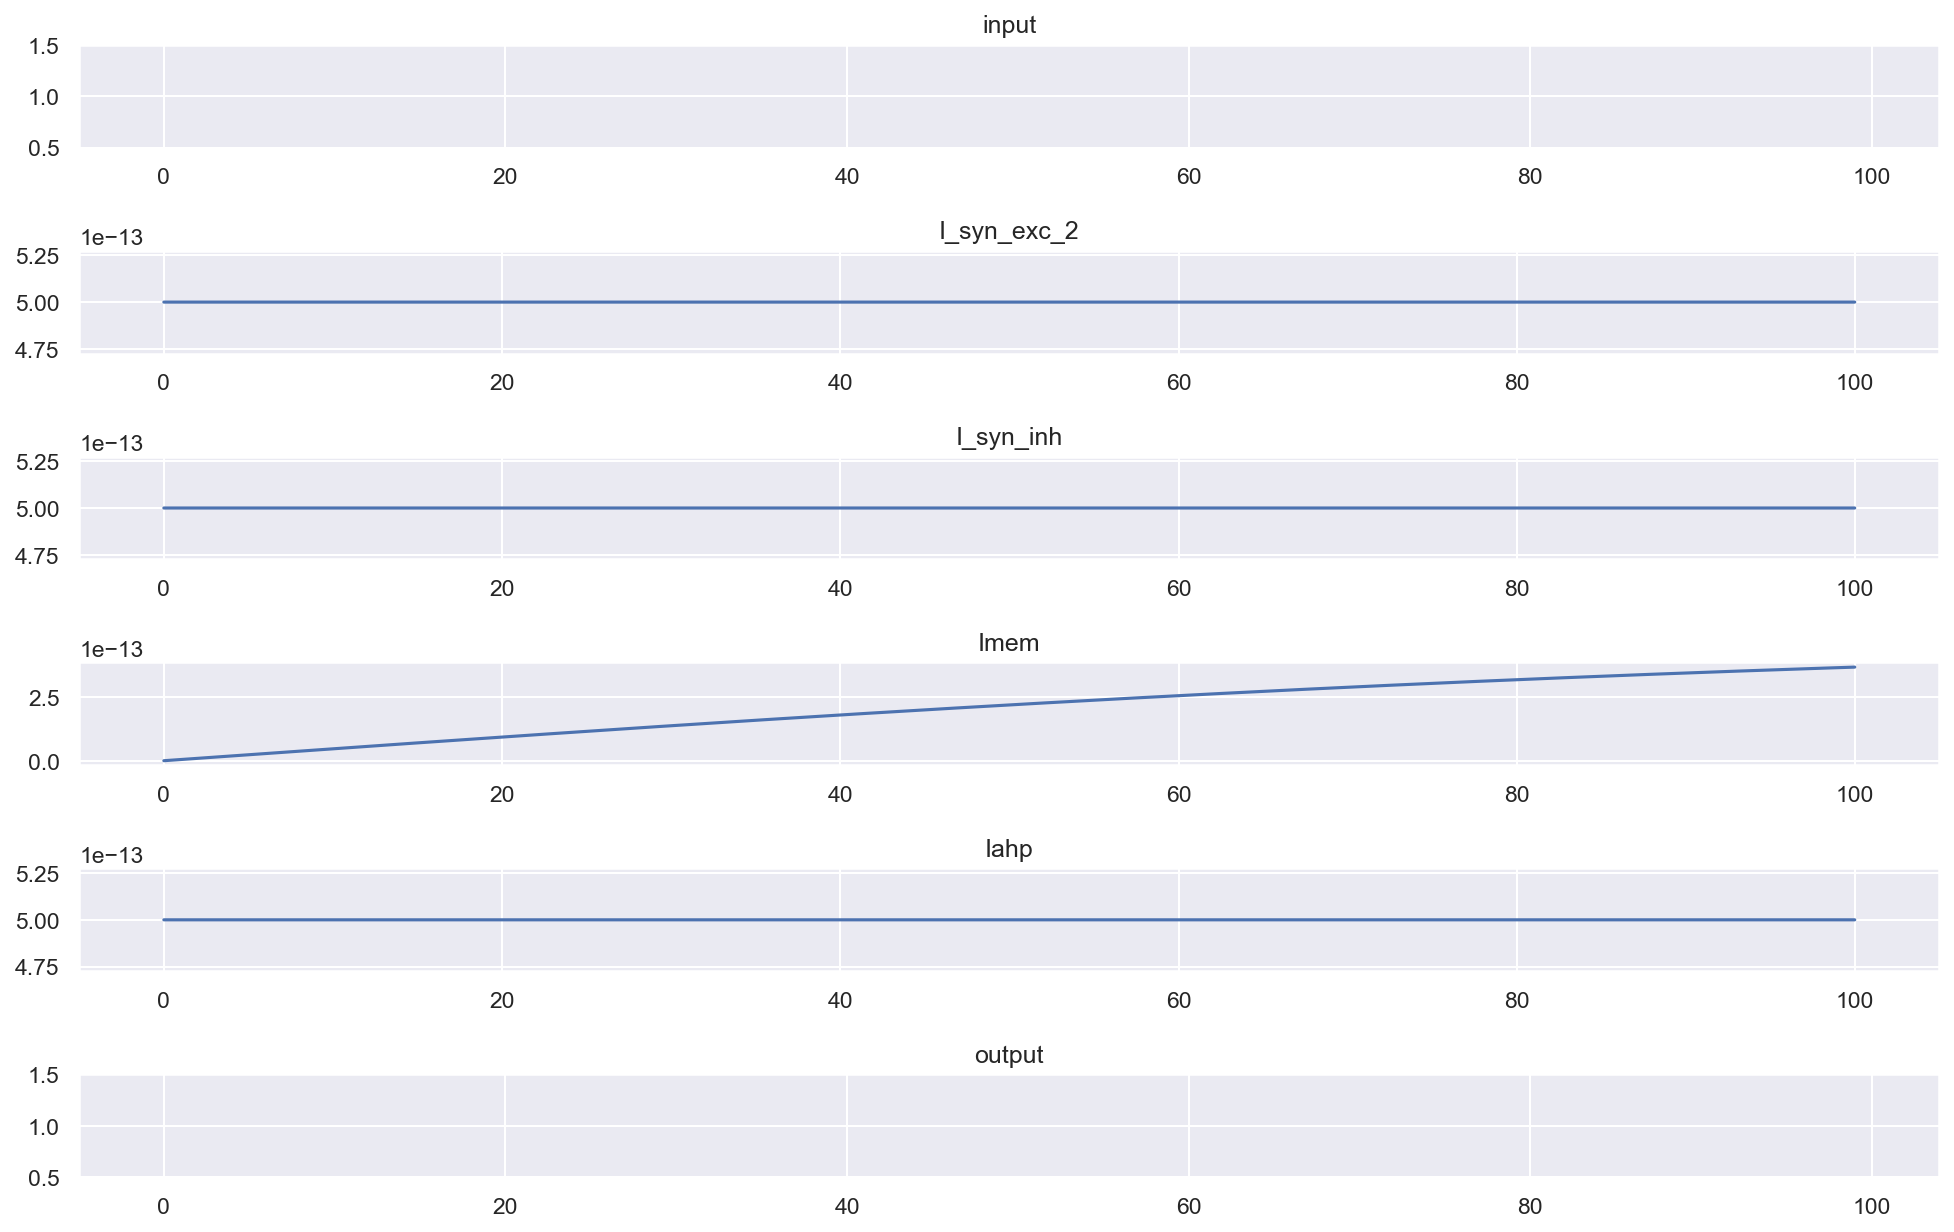

In [91]:
plt.figure(figsize=(16,10),dpi=150)
plt.subplots_adjust(hspace=1)

output_idx = 1

plt.subplot(611)
times = int(duration/ms)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
plt.ylim(0.5, 1.5)
plt.title('input')

plt.subplot(612)
plt.plot(mon_synapse_up_state.t / ms, mon_synapse_up_state.I_syn_exc2[output_idx])
plt.title('I_syn_exc_2')

plt.subplot(613)
plt.plot(mon_synapse_down_state.t / ms, mon_synapse_down_state.I_syn_inh[output_idx])
plt.title('I_syn_inh')

plt.subplot(614)
plt.plot(mon_neuron_state.t / ms, mon_neuron_state.Imem[output_idx])
plt.title('Imem')

plt.subplot(615)
plt.plot(mon_neuron_ahp.t / ms, mon_neuron_ahp.Iahp[output_idx])
plt.title('Iahp')


plt.subplot(616)
times = int(duration/ms)
spike_placeholder = np.zeros(times)
relevant_timestamps = mon_neuron_output.t[mon_neuron_output.i == output_idx]
spike_placeholder[np.array(relevant_timestamps/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
plt.ylim(0.5, 1.5)
plt.title('output')

plt.show()